# Capstone Project: Product Image Classification


## Project Overview

In this udacity course, I have been highly fascinated with image classification. Luckily for me I have found a project, hosted on Kaggle.com in partnership with Cdiscount, in which the goal is to classify images.

The company Cdiscount, is the largest non-food e-commerce company in France with over 30 million different products for sale. They want to be able to classify their product images to predict its respective product category. This is similar to how Amazon has a bunch of different categories for each of their products.

Currently Cdiscount classifies their products by analyzing the description of the products that the seller describes. Through a text classification algorithm, Cdiscount is able to classify the product into its respective product category (with some accuracy). However, now they want to go even further beyond, to improve their product classification accuracy. In order to do this, they are looking into image classification. Cdiscount wants to read the picture that the seller inputs to automatically classify the product into its correct category. Having the correct category for the product will make the experience easier for Cdiscount customers to find products from various sellers, and would make it easier for the sellers to acknowledge the correct category for the product they are selling.

## Problem Statement

Cdiscount provided no ordinary image classification problem. I have been given a little over seven million images from Cdiscount which I will use to train my model, and they want to be able to classify their products correctly into one of 5270 different categories. In this problem, I will implement a convolutional neural network to classify the image's categories.

### Solution 1 - The Solution that I backed away from, and my original thought to solving this problem

When I first started this problem, my goal was to implement a solution that would break this problem up into different sets of neural networks. I am going to explain my first thought process when I first went out to solve this problem.

I felt that 5270 different classes is a lot of labels to correctly predict which the image is associated with, which is why I thought of breaking this problem into mutliple sets of neural networks. Cdiscount also provided a file which nests each of the 5270 categories into more general categories. So as a concrete example, a backpack and a purse would be in the same general category as provided by Cdiscount, but their specific category would be different. I was going to create a convolutional neural network which predicted the general category of the product. Then after running the products through my first neural network, I wanted to create many neural networks that are specific to the general categories. 

So my machine learning pipeline would've looked like this:

1. Create and train a convolutional neural network which predicts the product's general category. There are 49 different general categories, so 49 different output nodes
2. Run each product through this neural network to predict its general category
3. Create and train new convolutional neural networks with products that have been predicted with a general category from the first neural network. This means that I will have 49 different neural networks that are specifically trained with products that within a general category. Each of these neural networks will have around 100 different output nodes. The logic for this is because 49 x 100 equals around 5000.

I decided not to follow up with this solution for many reasons, and will further explain why I ditched this solution later on when I test this out on a neural network in the solution statement section:

1. It was much more complicated to maintain and compile several neural networks and to train each one indiviually.
2. It would have taken longer to run this algorithm on the test data, which again was to predict the correct class of product using the first neural network, then the second neural network 
3. The accuracy of the highest validation was around 55%, which is not as high as I would've hoped. This is because it still has to go through a second neural network, which will for sure bring the accuracy down when testing the final prediction

### Solution 2 - Revised and implemented solution

This solution maintains the use of one convolutional neural network, but predicts the class of a product into one of 5270 specific product categories. The benefits of this is as follows:

1. It is much easier to maintain and implement one convolutional neural network 
2. Testing the accuracy on the test dataset will be faster
3. Due to only having one convolutional neural network, it will be easier to add new layers, nodes, or a new structure in general to validate different results
4. Transfer learning with one CNN is more efficient


### Various Miscellaneous Problems That Will Be Addressed Later in this Report

1. Storing and pre-processing the data
2. Memory and Storage Issues
2. Setting up Google Cloud Computing
3. Setting up CUDA GPU Computing

### Goals for this project

Each Kaggle competition has a leaderboard. My goal entering my first Kaggle competition is to be in the top 50th percentile. This means that I want to achieve an accuracy score on the test dataset that is higher than the median participant's accuracy score.

## Datasets and Inputs

### Data Processing

In order to process the data, Cdiscount provided a '.bson' file which contained all of the image data. This file is a mongoDB database data extract. It takes the form of a JSON-like structure. With this '.bson' file format, it is not that easy to access images. In the Kaggle competition, they gave us starter code to read the '.bson' file. I have edited the code to store the data in the format that I want, however, using this code is not what I initially wanted to do.

I initially tried many things to process the data to where it could be properly loaded into a neural network. I first tried to convert the 'train.bson' file using a mongoDB tool called 'bsondump' which was to convert the '.bson' file into a '.json' file. I did this because there were various Python modules where you can read in JSON files pretty easily. However, it turned out that the converted JSON file was in an incorrect file format for Python, and R programming languages to properly read in.

So I resulted to the code that they gave to read in a '.bson' file. However, the starter code that they gave us had no information on how to store the images. I wanted to store the images into an easily accessible file type that can store vasts amounts of data. I researched various file formats and saw that the 'H5' file format was able to store python arrays, and was able to handle vasts amount of data efficiently.

Below is the code for processing the data into '.H5' files. The result was 140 different H5 files which stored the image arrays. Each of these H5 files contained 50000 images. I used separate H5 files as well to story the productID as well as the categoryID, however, these files did not nearly need as much memory.

#### Loading the required packages for proccessing and storing the data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py # Used to store images and data

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from subprocess import check_output


import io
import bson                       # this is installed with the pymongo package
import matplotlib.pyplot as plt
from skimage.data import imread   

#### Processing the training dataset

I added a lot of things to the starter code that they gave us to process the BSON files. When I first started I ran into a problem. The problem was that the image arrays took a very long time to be appended together. The work around was to use pandas dataframes. I would temporarily use the pandas dataframes to append each image array in each cell under one column; this turned out to be a lot faster then appending two numpy arrays together. Then I converted the pandas column into a numpy array of image data. Each iteration of the loop contains 50,000 images and its respective category which is saved in H5 files.

The H5 files were too large to fit into my computer's storage, in total the images consumed around 800 GB. To solve this, I had to buy an external hard drive which I could store all the image data into. I then had to figure how to connect my iPython notebook to an external storage device which I was able to do with Windows symbolic links.

In [ ]:
# Simple data processing
from bson.json_util import dumps

# Read in the BSON file
data = bson.decode_file_iter(open('train.bson', 'rb'))

prod_to_category = dict()

# Initialize counters for the for loop to process and store image data
i = 0
j = 200000
k = 0
l = 0
dat = 1

for c, d in enumerate(data):
    product_id = d['_id']
    category_id = d['category_id'] # This won't be in Test data
    prod_to_category[product_id] = category_id
    i+=1
    k+=1
    l+=1
    
    #  print out the number of iterations the loop has went through
    if (i == j):
        print (i, "records loaded")
        print(picture_1.shape)
        j+=200000
        
        
    for e, pic in enumerate(d['imgs']):
        
        # It was much faster to append a single numpy picture array into a new cell in a pandas dataframe.
        # I initially tried to append a single numpy picture array into an existing numpy array with all the
        # previous image data, but this turned out to take a very long time
        if (l == 1):
            picture_1 = np.reshape(imread(io.BytesIO(pic['picture'])), (1,180,180,3))
            get = pd.DataFrame({'A': [product_id], 'B': [category_id], 'C':[picture_1]})
            frames = get
            break
            
        else:
            picture_2 = np.reshape(imread(io.BytesIO(pic['picture'])), (1,180,180,3))
            get2 = pd.DataFrame({'A': [product_id], 'B': [category_id], 'C':[picture_2]})
            frames = frames.append(get2)
            break
            
    # Once 'l' is equal to 50000, then convert the pandas columns into numpy arrays and write the data to an H5 file. 
    # This proved to be the fastest method to store the images and write them onto a file type that I can access later
    if (l == 50000):
        c = np.array(frames.C.tolist())
        c = c.reshape(l,180,180,3)
        #c = np.array(frames.C)
        b = np.array(frames.B)
        a = np.array(frames.A)
        

        h5f = h5py.File('Product_ID' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=a)
        
        h5f = h5py.File('Category_ID' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=b)
        
        h5f = h5py.File('Product_Image' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=c)
        
        h5f.close()            
        
        # Have to make sure that you set these arrays back to its original value or the arrays will get too big and the computer
        # will get slow and run out of memory. These variables will be appended with new values in the next iterations of the loop
        # until 'l' equals 50000 then these arrarys reset.
        a = None
        b = None
        c = None
        
        l = 0
        dat += 1
        
        # My computer auto-updated istelf before it finished this last itertion. 'k' was equal to the total number of pictures
        # in the dataset. I only was able to write 7000000 pictures onto H5 files. But this should be fine for the classification
        # problem
    elif (k == 7069894):
        c = np.array(frames.C.tolist())
        c = c.reshape(i,180,180,3)
        #c = np.array(frames.C)
        b = np.array(frames.B)
        a = np.array(frames.A)
        
        h5f = h5py.File('Product_ID' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=a)
        
        h5f = h5py.File('Category_ID' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=b)
        
        h5f = h5py.File('Product_Image' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=c)
        
        h5f.close()
        
        break

#### Processing the testing dataset

The test dataset for this problem consisted of 1,768,182 images. I did the same process here as in processing the training dataset by storing 50,000 images and the categoryId into multiple H5 files, with the last H5 file containing less than 50,000 images to evenly add up to the total amount of images.

In [8]:
# Read in the BSON file
data = bson.decode_file_iter(open('test.bson', 'rb'))

prod_to_category = dict()

# Initialize counters for the for loop to process and store image data
i = 0
j = 200000
k = 0
l = 0
dat = 1

for c, d in enumerate(data):
    product_id = d['_id']
    i+=1
    k+=1
    l+=1
    
    #  print out the number of iterations the loop has went through
    if (i == j):
        print (i, "records loaded")
        print(picture_1.shape)
        j+=200000
        
        
    for e, pic in enumerate(d['imgs']):
        
        # It was much faster to append a single numpy picture array into a new cell in a pandas dataframe.
        # I initially tried to append a single numpy picture array into an existing numpy array with all the
        # previous image data, but this turned out to take a very long time
        if (l == 1):
            picture_1 = np.reshape(imread(io.BytesIO(pic['picture'])), (1,180,180,3))
            get = pd.DataFrame({'A': [product_id], 'C':[picture_1]})
            frames = get
            break
            
        else:
            picture_2 = np.reshape(imread(io.BytesIO(pic['picture'])), (1,180,180,3))
            get2 = pd.DataFrame({'A': [product_id], 'C':[picture_2]})
            frames = frames.append(get2)
            break
            
    # Once 'l' is equal to 50000, then convert the pandas columns into numpy arrays and write the data to an H5 file. 
    # This proved to be the fastest method to store the images and write them onto a file type that I can access later
    if (l == 50000):
        c = np.array(frames.C.tolist())
        c = c.reshape(l,180,180,3)
        #c = np.array(frames.C)
        a = np.array(frames.A)
        

        h5f = h5py.File('./test/Product_IDtest' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=a)
        
        h5f = h5py.File('./test/Product_Imagetest' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=c)
        
        h5f.close()            
        
        # Have to make sure that you set these arrays back to its original value or the arrays will get too big and the computer
        # will get slow and run out of memory. These variables will be appended with new values in the next iterations of the loop
        # until 'l' equals 50000 then these arrarys reset.
        a = None
        c = None
        
        l = 0
        dat += 1
        
        # My computer auto-updated istelf before it finished this last itertion. 'k' was equal to the total number of pictures
        # in the dataset. I only was able to write 7000000 pictures onto H5 files. But this should be fine for the classification
        # problem
    elif (k == 1768182):
        c = np.array(frames.C.tolist())
        c = c.reshape(len(frames),180,180,3)
        #c = np.array(frames.C)
        a = np.array(frames.A)
        
        h5f = h5py.File('./test/Product_IDtest' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=a)
        
        h5f = h5py.File('./test/Product_Imagetest' + str(dat) + '.h5', 'w')
        h5f.create_dataset('dataset', data=c)
        
        h5f.close()
        
        break

200000 records loaded
(1, 180, 180, 3)
400000 records loaded
(1, 180, 180, 3)
600000 records loaded
(1, 180, 180, 3)
800000 records loaded
(1, 180, 180, 3)
1000000 records loaded
(1, 180, 180, 3)
1200000 records loaded
(1, 180, 180, 3)
1400000 records loaded
(1, 180, 180, 3)
1600000 records loaded
(1, 180, 180, 3)


#### Visualization - Pictures

Below are examples of the pictures that Cdiscount has provided for us. There are many different types of products, ranging from phone cases to batteries to CD albums to many more thousands of different objects.

AxesImage(54,36;334.8x217.44)


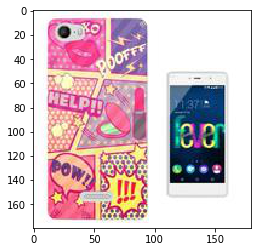

In [63]:
%matplotlib inline
print (plt.imshow(pic_arr2[10]))

AxesImage(54,36;334.8x217.44)


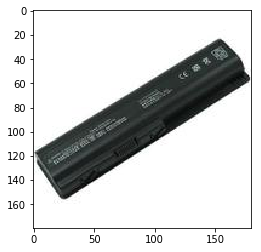

In [61]:
print (plt.imshow(pic_arr2[2000]))

AxesImage(54,36;334.8x217.44)


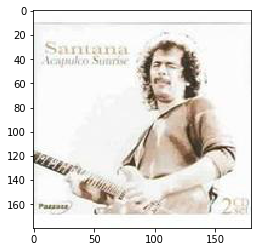

In [64]:
print (plt.imshow(pic_arr2[3000]))

#### Categories

Cdiscount provided the 'category_names.csv' file shown below. This file contains a list of 5270 different 'category_ids'. However, I made modifications inside this file and used an excel function to append a new column, 'cat_1_encode'. This column basically encodes the 'category_level1' column into integer values ranging from 0-48. I have also appended a column 'catID_encode' which encodes the 'category_id'; so 'catID_encode' has integer values ranging from 0-5269. This is because there are 5270 different categories in total. I also appended a new column, 'cat_2_encode' which does the same to the 'category_level2' column (however I did not use this category level in my project).

In [5]:
# Read in the CSV file which has the categories names of each of the category IDs
categories_df = pd.read_csv('category_names.csv')
categories_df.head()

,category_id,category_level1,category_level2,category_level3,cat_1_encode,catID_encode,cat_2_encode,cat_1_encodep2
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0,0,0,0
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1,1,1,0
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,1,2,1,1
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,1,3,1,2
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,1,4,2,3


#### Creating the Final Training Set - One hot encoding 'cat_1_encode' column

In this project, I am consuming tons of memory when trying to divide my numpy arrays by 255. I originally had a laptop that only had 8GB of RAM and that always ended up in a resource exhaust error because I did not have enough memory to divide the images.

I went to attempt to use the Google Cloud compute. I had the virtual machine set up in the cloud. However, there were even further problems that arose from trying to use cloud computing. First, when I transferred files from my local workstation to the cloud, it took around three days to transfer over 200,000 images. This was most likely that my bandwidth was slow, but even with a better bandwidth, it still would have taken a while. Another problem with Google Cloud is that renting out a server with GPU compute capabiltity cost over 1000 dollars a month which I did not even want to attempt setting up that workstation, even with the free 300 dollar credit that they initially give.

I decided to just buy a new laptop with more compute power (32 GB RAM) and a NVIDIA GPU. Even with a lot more memory, my new computer often froze when trying to divide the whole 50,000 numpy array by 255. 

I am dividing the image array by the value of 255 because it is the maximum pixel value and we need to get each value in the picture array to be a value between zero and one. Our predictions will be much more accurate when we have our input values closer together. 

I am going to only use 1,000,000 of the images provided to fit my models due to the amount of time training. These 1,000,000 images, I need to reformat by dividing each picture's pixels by 255. If need be I will increase the amount of data I will use in this project.

I will create training data corresponding to the 'cat_1_encode' column. In the code below, I am also saving the training data into H5 files so that it can be easily accessed later without taking up too much memory on my machine.

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import numpy as np
import pandas as pd
import h5py 

# I am going to categorically encode the 'cat_1_encode' column into an array of values from 0-1. 
# Then append this array as a new column in the dataframe.
#catID_HOTencode_arr = np_utils.to_categorical(np.array(categories_df.catID_encode))
#categories_df['ONE_HOT'] = list(catID_HOTencode_arr)
catID_HOTencode_arr = np_utils.to_categorical(np.array(categories_df.cat_1_encode))
categories_df['ONE_HOT'] = list(catID_HOTencode_arr)

# There are 140 H5 picture files containing 50000 images each. Reading in each file at a time
for i in range(1,7):
    
    if (i > 1):
        from keras.utils import np_utils
        import numpy as np
        import pandas as pd
        import h5py
        
        categories_df = pd.read_csv('category_names.csv')
        catID_HOTencode_arr = np_utils.to_categorical(np.array(categories_df.cat_1_encode))
        categories_df['ONE_HOT'] = list(catID_HOTencode_arr)


    # Read in the category ID
    h5f = h5py.File('Category_ID' + str(i) + '.h5','r')
    cat_arr = h5f['dataset'][:]

    # Read in the product image
    h5f = h5py.File('Product_Image' + str(i) + '.h5','r')
    pic_arr = h5f['dataset'][:]
    h5f.close()

    # Create a temporary dataframe, which binds the categoryID array with its associated picture array. 
    temp_df = pd.DataFrame({'category_id':cat_arr, 'image': list(pic_arr)})
    # Set these values to None to save memory on my machine.
    cat_arr = None
    pic_arr = None

    # Now to merge this temp_df dataframe with the categories_df dataframe, I am going to merge on category_id
    # The result of this is a dataframe, that includes 50000 records that have the categoryIds that were located in the H5 file
    # and also now has the categorical array which represents the true class of the general category
    temp2_df = pd.merge(temp_df, categories_df, how='inner')
    temp_df = None  # Set value to None to save memory

    # This is used to randomize/shuffle the rows of the dataframe. So that we can have random training and test validation sets.
    temp2_df = temp2_df.sample(frac=1).reset_index(drop=True)

    # Now to create my train and validation sets, 20% (10000) of the records are for validation, 80% (40000) of the records
    # are for training
    x_train = np.array(np.array(temp2_df.image.tolist()) / 255, dtype = 'f')
    y_train = np.array(temp2_df.ONE_HOT.tolist(), dtype = 'f')

    h5f = h5py.File('x_train' + str(i) + '.h5', 'w')
    h5f.create_dataset('dataset', data=x_train)
    h5f = h5py.File('y_train' + str(i) + '.h5', 'w')
    h5f.create_dataset('dataset', data=y_train)
    h5f.close()

    from IPython import get_ipython
    get_ipython().magic('reset -sf')

Using TensorFlow backend.


#### Creating Training Sets - One hot encoding 'catID_encode' column

I will also create the training sets for the 'catID_encode' column. This means that each of the pictures provided will need to be reformatted by dividing each pixel by 255, similar to what is done above. The difference here is that each of these pictures will be associated with its respective label that ranges from 0-5269, because there are 5270 unique category IDs.

I will save 1,000,000 images and its respective category ID label in H5 files.

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import numpy as np
import pandas as pd
import h5py 

# I am going to categorically encode the 'cat_1_encode' column into an array of values from 0-1. 
# Then append this array as a new column in the dataframe.
catID_HOTencode_arr = np_utils.to_categorical(np.array(categories_df.catID_encode))
categories_df['ONE_HOT'] = list(catID_HOTencode_arr)

# There are 140 H5 picture files containing 50000 images each. Reading in each file at a time
for i in range(0,41):
    
    if (i > 1):
        from keras.utils import np_utils
        import numpy as np
        import pandas as pd
        import h5py
        
        categories_df = pd.read_csv('category_names.csv')
        catID_HOTencode_arr = np_utils.to_categorical(np.array(categories_df.catID_encode))
        categories_df['ONE_HOT'] = list(catID_HOTencode_arr)


    # Read in the product image
    h5f = h5py.File('Product_Image' + str(i) + '.h5','r')
    pic_arr = h5f['dataset'][:]   
        
    # Read in the category ID
    h5f = h5py.File('Category_ID' + str(i) + '.h5','r')
    cat_arr = h5f['dataset'][:]

    h5f.close()

    # Create a temporary dataframe, which binds the categoryID array with its associated picture array. 
    temp_df = pd.DataFrame({'category_id':cat_arr, 'image': list(pic_arr)})
    # Set these values to None to save memory on my machine.
    del cat_arr
    del pic_arr

    # Now to merge this temp_df dataframe with the categories_df dataframe, I am going to merge on category_id
    # The result of this is a dataframe, that includes 50000 records that have the categoryIds that were located in the H5 file
    # and also now has the categorical array which represents the true class of the general category
    temp2_df = pd.merge(temp_df, categories_df, how='inner')
    del temp_df  # Set value to None to save memory

    # This is used to randomize/shuffle the rows of the dataframe. So that we can have random training and test validation sets.
    temp2_df = temp2_df.sample(frac=1).reset_index(drop=True)

    # Now to create my train and validation sets, 20% (10000) of the records are for validation, 80% (40000) of the records
    # are for training
    x_train = pd.DataFrame()
    for k in range(0,50000):
        x_trainSubset = np.array(temp2_df.iloc[k]['image'] / 255, dtype = 'f')
        temp_df = pd.DataFrame({'pic_array': [x_trainSubset]})
        x_train = x_train.append(temp_df)

    del x_trainSubset
    del temp_df
    
    y_train = np.array(temp2_df.ONE_HOT.tolist(), dtype = 'f')
    del temp2_df
    x_train = np.array(x_train.pic_array.tolist(), dtype = 'f')
    
    # Export train and test sets to H5 files
    h5f = h5py.File('x_train' + str(i) + 'catID.h5', 'w')
    h5f.create_dataset('dataset', data=x_train)
    h5f = h5py.File('y_train' + str(i) + 'catID.h5', 'w')
    h5f.create_dataset('dataset', data=y_train)
    h5f.close()

    from IPython import get_ipython
    get_ipython().magic('reset -sf')

## Benchmark Model - Logistic Regression - Ignore this section, wasn't able to use this as benchmark model

My baseline model is logistic regression. I will only use 10,000 image observations to run and fit my logistic regression model through. This is because of memory limitations for sklearn logistic regression package; I initally tried to do 50,000 images but there was no sign it was ever going to finish running. I will use 10,000 image observations to validate the fitted logistic regression model. 

The goal here is to see the accuracy that logistic regression has when classifying the images in this dataset. I ultimately want to build a convolutional neural network which should have a higher accuracy then this logistic regression model.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Read in the category ID
h5f = h5py.File('y_train1catID.h5','r')
cat_arr = h5f['dataset'][:]

# Read in the product image
h5f = h5py.File('x_train1catID.h5','r')
pic_arr = h5f['dataset'][:]
h5f.close()

# Transform this into a picture array from three dimensions to two dimensions. This is because sklearn's logistic 
# regression package can't accept more than two dimensions
dataset_size = len(pic_arr)
pic_arr = pic_arr.reshape(dataset_size,-1)

# Now to create my train and validation sets, 20% (10000) of the records are for validation, 80% (40000) of the records
# are for training
x_train = np.array(pic_arr[0:40000])
y_train = np.array(cat_arr[0:40000])
x_val = np.array(pic_arr[40000:50000])
y_val = np.array(cat_arr[40000:50000])
temp2_df = None

# Initialize the logistic regression classifier for multi-class
clf = LogisticRegression(multi_class = 'multinomial', solver = 'sag', n_jobs = 4, max_iter=10, verbose=1)

# Fit the model with training image data and their true label
clf.fit(x_train, y_train)

# Get the accuracy score of the fitted model on the validation set
clf.score(x_val, y_val)

## Solution Statement - Using Validation Accuracy as Evaluation Metric

In this section I have tested various convolutional neural network structures to determine which would obtain the highest accuracy score.

A convolutional neural network is one of the best ways to categorize image data in today's world. The reason for this is because of its success in image training competitions such as ImageNet. Another benefit of convolutional neural networks is that you can combine nodes together from one layer to the next to create even more complex non-linear classifiers. With 5270 different images in the dataset, it is probably safe to say that we would need a complex classifier that can distinguish many unique patterns within various images.

#### CPU and GPU summary

This is the information on the CPU and GPU that I'm using. I am using a NVIDIA GTX 1070 GPU and have set it up correctly to work with Tensorflow. The GPU on my computer will make it a lot faster to train the convolutional neural network.

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10259264407376851264
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6762058875
locality {
  bus_id: 1
}
incarnation: 1234559033269605352
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
import psutil
psutil.virtual_memory()

svmem(total=34314883072, available=31125389312, percent=9.3, used=3189493760, free=31125389312)

### Testing Solution 1

#### Experiment 1 - Based on Solution 1

I am going to use the following structure for this neural network, this is the first neural network in which the goal is to classify each of the images into its general category that includes 49 different classes.

We want to specifically declare the Relu activation function because it mitigates the vanishing gradient problem. Since the gradient of the relu activation function is one if the output is greater than zero, is is much easier for the backpropogation step to more quickly find a local or global minimum which minimizes the error function in our model.

In [6]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 80 filters/nodes in the second layer. The kernel size will be four, which means that each filter will cover a 4px
# by 4px area to find a pattern. The filter will move across the image array two pixels at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=80, kernel_size=4, strides=2, activation='relu', input_shape=(180, 180, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=60, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fully connected layer
model.add(Dense(units = 40, activation = 'relu'))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 49 different possible output nodes that the product can be classified as
#model.add(Dense(units=5270, activation='softmax'))
model.add(Dense(units=49, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer rmsprop is efficient with quickly minimizing error. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 89, 89, 80)        3920      
_________________________________________________________________
dropout_1 (Dropout)          (None, 89, 89, 80)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 80)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 60)        19260     
_________________________________________________________________
dropout_2 (Dropout)          (None, 43, 43, 60)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 60)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 21, 21, 40)        2440      
__________

#### Training my model

To train my model, I am going to use a for loop to read in each of the H5 files. With the image array data, I am going to feed that into my neural network to train it. So 50000 images are going to be fed into the neural network for one iteration of the for loop, then the next 50000, and so on. I am going to load the model weights from the previous epoch so that my neural network can continue training, but on a different set of the next 50000 images.

I found that I needed a GPU because it took a very long time for me tor train a neural network using just a CPU. I was also only able to train my model with 20 images at a time (batch size) due to an initial error I received that says that my system was exhausted of memory resources; I initally wanted to train my model with 1000 images at a time. 

In [7]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import numpy as np
import h5py
import tensorflow as tf

# This is used to store the best weights for our trained model. We can access this later. This is a work-around for
# early-stopping, to save the best weights that minimize the error for both the training and validation sets
checkpointer = ModelCheckpoint(filepath='weights_best.hdf5', 
                           verbose=1, save_best_only=True)

# There are 6 formatted H5 picture files containing 50000 images each. Reading in each file at a time
for i in range(1,7):
    
    # Read in the product image
    h5f = h5py.File('x_train' + str(i) + '.h5','r')
    pic_arr = h5f['dataset'][:]
    
    # Read in the category ID
    h5f = h5py.File('y_train' + str(i) + '.h5','r')
    cat_arr = h5f['dataset'][:]
    h5f.close()
    
    # Now to create my train and validation sets, 20% (10000) of the records are for validation, 80% (40000) of the records
    # are for training
    x_train = np.array(pic_arr[0:40000])
    y_train = np.array(cat_arr[0:40000])
    x_val = np.array(pic_arr[40000:50000])
    y_val = np.array(cat_arr[40000:50000])

    # Free up memory
    del pic_arr
    del cat_arr

    # Load the model weights after the first iteration of the loop, so that we can continue training the weights from 
    # previous models
    if (i > 1):
        model = load_model('my_model.h5')
    
    # Specify GPU to fit the model
    with tf.device('/device:GPU:0'):
        # Fit the model to run the neural network. The batch size is at 1000, meaning that each epoch will run 40 times, since
        # the training set size is 40000 records. The model will do one backpropogation step for all the records in each batch.
        model.fit(x_train, y_train, 
                        batch_size = 20,
                        epochs = 1,
                        validation_data=(x_val, y_val),
                        callbacks=[checkpointer],
                        verbose=1)

    # Save the model weights into an Hdf5 file. Then we will load the model this model weights for the next iteration of the loop
    model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

    # Free up space/memory
    del x_train
    del y_train
    del x_val
    del y_val
    del model

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 844s - loss: 1.9116 - acc: 0.5402 - val_loss: 2.1015 - val_acc: 0.5756
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 695s - loss: 2.5835 - acc: 0.3565 - val_loss: 2.7337 - val_acc: 0.3516
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 938s - loss: 2.5848 - acc: 0.3416 - val_loss: 2.4990 - val_acc: 0.3504
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 993s - loss: 2.5838 - acc: 0.3382 - val_loss: 2.6028 - val_acc: 0.3131
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 940s - loss: 2.5800 - acc: 0.3313 - val_loss: 2.5401 - val_acc: 0.3246
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 925

#### Results - Experiment 1

It appears that from each of the six epochs, it was the first epoch that actually was able to reduce the most error in the model and obtain the highest accuracy, with a validation accuracy of 57.6%. This is most likely because not all of the categories were included within the first 50,000 images.

However, training a model like this seemed very innefficient. This is because a single epoch is supposed to conist of the entire training dataset, and here an epoch consisted of a different batch of 50,000 images. I initially thought that just by loading the model weights from the previous batch of 50,000 images to train on the next 50,000 images would do the trick, but it was not efficient.

The goal of this first convolutional neural network was to be able to classify an image into 49 general categories instead of 5270 unique classes. What I was imagining was that I would run the image through the fitted neural network model which will predict into one of 49 different general categories. Then from there, the image would be transferred to a specific fitted neural network that has all the specific unique classes in the general category.

#### Experiment 2 - Based on Solution 1, Training using fit_generator

After doing some research it appeared that the best way to read in multiple image files for training under one epoch was to use the 'fit_generator' function in Keras. With this function I was able to loop in all of the images under a single epoch to train. This was a lot more efficient than what I performed above.

Below are the generator functions that I used for my train and validation datasets. With these generator functions I split my dataset into 80% for train and 20% for validation

In [5]:
import h5py

# Create a function to process the training data for the generator
def train_generator():
    counter = 1
    batch_size = 20
    
    while True:
    
        # Create arrays to contain x_train and y_train. There are six of these files in total, so 40000*6 = 240,000 items in the entire training set.
        # 300,000 images for each epoch
        h5f = h5py.File('x_train' + str(counter) + '.h5','r')
        pic_arr = h5f['dataset'][0:40000]

        h5f = h5py.File('y_train' + str(counter) + '.h5','r')
        cat_arr = h5f['dataset'][0:40000]
        h5f.close()
        
        # Since training size for each dataset is 40,000 and batch_size is 20, loop 2000 times because 40000/20 = 2000 
        for i in range(1,2001):
            if (i == 1):
                x_train = pic_arr[0:batch_size]
                y_train = cat_arr[0:batch_size]

                index = batch_size
                yield x_train, y_train
            else:
                x_train = pic_arr[index:index + batch_size]
                y_train = cat_arr[index:index + batch_size]

                index += batch_size
                yield x_train, y_train
                
        del pic_arr
        del cat_arr
        counter += 1
        if (counter == 7):
            counter = 1

# Create a function to define a generator for the validation set
def validation_generator():
    counter = 1
    batch_size = 20
    
    while True:
    
        # Create arrays to contain x_train and y_train. There are seven of these files in total, so 10000*20 = 200000 items in entire validation set.
        # 200,000 images for each epoch
        h5f = h5py.File('x_train' + str(counter) + '.h5','r')
        pic_arr = h5f['dataset'][40000:50000]

        h5f = h5py.File('y_train' + str(counter) + '.h5','r')
        cat_arr = h5f['dataset'][40000:50000]
        h5f.close()
        
        # Since training size for each dataset is 10,000 and batch_size is 20, loop 500 times because 10000/20 = 500 
        for i in range(1,501):
            if (i == 1):
                x_val = pic_arr[0:batch_size]
                y_val = cat_arr[0:batch_size]

                index = batch_size
                yield x_val, y_val
            else:
                x_val = pic_arr[index:index + batch_size]
                y_val = cat_arr[index:index + batch_size]

                index += batch_size
                yield x_val, y_val
                
        del pic_arr
        del cat_arr
        counter += 1
        if (counter == 7):
            counter = 1
        

In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 100 filters/nodes in the second layer. The kernel size will be four, which means that each filter will cover a 4px
# by 4px area to find a pattern. The filter will move across the image array one pixels at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=100, kernel_size=4, strides=1, activation='relu', input_shape=(180, 180, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=80, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=60, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fully connected layer
model.add(Dense(units = 40, activation = 'relu'))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 49 different possible output nodes that the product can be classified as
model.add(Dense(units=49, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer adam is efficient with quickly minimizing error with momentum. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 177, 177, 100)     4900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 177, 177, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 80)        32080     
_________________________________________________________________
dropout_2 (Dropout)          (None, 87, 87, 80)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 60)        19260     
__________

In [6]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# This is used to store the best weights for our trained model.
checkpointer = ModelCheckpoint(filepath='weights_bestID1Generator.hdf5', 
                           verbose=1, save_best_only=True)

# steps_per_epoch=12000 because --> 240,000 (total samples) / 20 (batch size) = 12000
# validation_steps=3000 because --> 60,000 (total samples) / 20 (batch size) = 3000
with tf.device('/device:GPU:0'):
    m = model.fit_generator(generator = train_generator(), steps_per_epoch=12000, epochs=10, 
                        validation_data = validation_generator(), validation_steps=3000,
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/10
12000/12000 [==============================] - 4583s - loss: 1.8971 - acc: 0.5068 - val_loss: 2.1881 - val_acc: 0.4050
Epoch 2/10
12000/12000 [==============================] - 4901s - loss: 1.6000 - acc: 0.5766 - val_loss: 1.8307 - val_acc: 0.5220
Epoch 3/10
12000/12000 [==============================] - 4921s - loss: 1.4890 - acc: 0.6004 - val_loss: 1.7824 - val_acc: 0.5469
Epoch 4/10
12000/12000 [==============================] - 4931s - loss: 1.4210 - acc: 0.6150 - val_loss: 1.7733 - val_acc: 0.5499
Epoch 5/10
12000/12000 [==============================] - 4960s - loss: 1.3741 - acc: 0.6245 - val_loss: 1.7863 - val_acc: 0.5457
Epoch 6/10
12000/12000 [==============================] - 4998s - loss: 1.3376 - acc: 0.6327 - val_loss: 1.7553 - val_acc: 0.5542
Epoch 7/10
12000/12000 [==============================] - 5188s - loss: 1.3069 - acc: 0.6383 - val_loss: 1.7814 - val_acc: 0.5494
Epoch 8/10
12000/12000 [==============================] - 5010s - loss: 1.2860 - acc: 0.64

#### Results - Experiment 2

I will not continue with the same solution structure due to the results I recieved. I believe that since the general product categories are so broad, some products may share patterns with others products in different general categories and the accuracy is not as high as I hoped. 

Due to a low accuracy and the training time that it will take to train many different neural networks, I will go ahead and see if I can just implement one convolutional neural network that directly predicts the product into its specific class that includes 5270 different classes.

### Testing Solution 2 - The solution I Implemented

Now I am going to directly predict images into its specific class that includes 5270 different classes. Predicting directly into the specific category will save a lot of training time and make things simpler to manage. It will also make it much easier to experiment with the neural network's structure by adding any layers, filters, or nodes to improve the accuracy. I am implementing the 'fit_generator' function in all of the experiments for solution 2.

For the first five experiments I will train on 800,000 images and validate on 200,000 images. I expanded the number of images to train on because with a larger class size of 5270 different classes, I needed to make sure that there were enough samples for the neural network to distinguish unique patterns amongst all the classes.

The first three experiments will have the same neural network structure (same number of nodes, layers, etc.), but with different optimizers to minimize error. The first experiment I will try Rmsprop, the second Adam, and the third will be Adadelta.

The fourth and fifth experiments will be about changing the structure of the neural network, but using the optimizer that achieved the highest validation accuracy from the first three experiments. The fourth experiment, I will restructure a custom model on how I see fit, then with the fifth experiment, I will use transfer learning to train the Inception model with the data.

In [6]:
import h5py

# Create training generator
def train_generator():
    counter = 1
    batch_size = 20
    
    while True:
    
        # Create arrays to contain x_train and y_train. There are twenty of these files in total, so 40000*20 = 800,000 items in the entire training set.
        # 800,000 images for each epoch
        h5f = h5py.File('x_train' + str(counter) + 'catID.h5','r')
        pic_arr = h5f['dataset'][0:40000]

        h5f = h5py.File('y_train' + str(counter) + 'catID.h5','r')
        cat_arr = h5f['dataset'][0:40000]
        h5f.close()
        
        # Since training size for each dataset is 40,000 and batch_size is 20, loop 400 times because 40000/20 = 2000 
        for i in range(1,2001):
            if (i == 1):
                x_train = pic_arr[0:batch_size]
                y_train = cat_arr[0:batch_size]

                index = batch_size
                yield x_train, y_train
            else:
                x_train = pic_arr[index:index + batch_size]
                y_train = cat_arr[index:index + batch_size]

                index += batch_size
                yield x_train, y_train
                
        del pic_arr
        del cat_arr
        counter += 1
        if (counter == 21):
            counter = 1

# Create validation generator
def validation_generator():
    counter = 1
    batch_size = 20
    
    while True:
    
        # Create arrays to contain x_train and y_train. There are twenty of these files in total, so 10000*20 = 200000 items in entire validation set.
        # 200,000 images for each epoch
        h5f = h5py.File('x_train' + str(counter) + 'catID.h5','r')
        pic_arr = h5f['dataset'][40000:50000]

        h5f = h5py.File('y_train' + str(counter) + 'catID.h5','r')
        cat_arr = h5f['dataset'][40000:50000]
        h5f.close()
        
        # Since training size for each dataset is 10,000 and batch_size is 20, loop 500 times because 10000/20 = 500 
        for i in range(1,501):
            if (i == 1):
                x_val = pic_arr[0:batch_size]
                y_val = cat_arr[0:batch_size]

                index = batch_size
                yield x_val, y_val
            else:
                x_val = pic_arr[index:index + batch_size]
                y_val = cat_arr[index:index + batch_size]

                index += batch_size
                yield x_val, y_val
                
        del pic_arr
        del cat_arr
        counter += 1
        if (counter == 21):
            counter = 1
        

#### Experiment 1 - Training using Rmsprop optimizer

In [5]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 100 filters/nodes in the second layer. The kernel size will be four, which means that each filter will cover a 4px
# by 4px area to find a pattern. The filter will move across the image array one pixel at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=100, kernel_size=4, strides=1, activation='relu', input_shape=(180, 180, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=80, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=60, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fully connected layer
model.add(Dense(units = 40, activation = 'relu'))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 5270 different possible output nodes that the product can be classified as
model.add(Dense(units=5270, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer adam is efficient with quickly minimizing error with momentum. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 177, 177, 100)     4900      
_________________________________________________________________
dropout_4 (Dropout)          (None, 177, 177, 100)     0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 88, 88, 100)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 80)        32080     
_________________________________________________________________
dropout_5 (Dropout)          (None, 87, 87, 80)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 42, 42, 60)        19260     
__________

In [ ]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# This is used to store the best weights for our trained model.
checkpointer = ModelCheckpoint(filepath='weights_bestcatIDGenerator.hdf5', 
                           verbose=1, save_best_only=True)

# steps_per_epoch=40000 because --> 800,000 (total samples) / 20 (batch size) = 40000
# validation_steps=10000 because --> 200,000 (total samples) / 20 (batch size) = 10000
with tf.device('/device:GPU:0'):
    model.fit_generator(generator = train_generator(), steps_per_epoch=40000, epochs=18, 
                        validation_data = validation_generator(), validation_steps=10000, 
                        verbose = 1, callbacks=[checkpointer])

# with tf.device('/device:GPU:0'):
#     model.fit_generator(generator = train_generator(), steps_per_epoch=2000, epochs=2, 
#                         validation_data = validation_generator(), validation_steps=500, 
#                         verbose = 1, callbacks=[checkpointer])

Epoch 1/18
40000/40000 [==============================] - 10889s - loss: 6.7121 - acc: 0.1531 - val_loss: 7.5741 - val_acc: 0.1101
Epoch 2/18
40000/40000 [==============================] - 10935s - loss: 7.2933 - acc: 0.1532 - val_loss: 8.3542 - val_acc: 0.1063
Epoch 3/18
40000/40000 [==============================] - 10980s - loss: 7.4593 - acc: 0.1448 - val_loss: 8.5523 - val_acc: 0.1210
Epoch 4/18
40000/40000 [==============================] - 10915s - loss: 8.1101 - acc: 0.0953 - val_loss: 9.6641 - val_acc: 0.0117
Epoch 5/18
40000/40000 [==============================] - 10977s - loss: 9.2982 - acc: 0.0180 - val_loss: 9.5714 - val_acc: 0.0117
Epoch 6/18
40000/40000 [==============================] - 10884s - loss: 9.2741 - acc: 0.0187 - val_loss: 9.5695 - val_acc: 0.0117
Epoch 7/18
40000/40000 [==============================] - 10838s - loss: 9.2731 - acc: 0.0187 - val_loss: 9.5691 - val_acc: 0.0117
Epoch 8/18
15683/40000 [==========>...................] - ETA: 5644s - loss: 10.171

#### Results

The first epoch, returned the highest validation accuracy of 15.3%. Although it says I ran this experiment for 18 epochs, I stopped it after 8 because the validation loss kept on increasing; meaning the validation accuracy kept on declining.

#### Experiment 2 - Training using Adam

In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 100 filters/nodes in the second layer. The kernel size will be four, which means that each filter will cover a 4px
# by 4px area to find a pattern. The filter will move across the image array one pixels at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=100, kernel_size=4, strides=1, activation='relu', input_shape=(180, 180, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=80, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=60, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fully connected layer
model.add(Dense(units = 40, activation = 'relu'))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 5270 different possible output nodes that the product can be classified as
model.add(Dense(units=5270, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer adam is efficient with quickly minimizing error with momentum. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 177, 177, 100)     4900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 177, 177, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 80)        32080     
_________________________________________________________________
dropout_2 (Dropout)          (None, 87, 87, 80)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 60)        19260     
__________

In [3]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# This is used to store the best weights for our trained model.
checkpointer = ModelCheckpoint(filepath='weights_bestcatIDGeneratorAdam.hdf5', 
                           verbose=1, save_best_only=True)

# steps_per_epoch=40000 because --> 800,000 (total samples) / 20 (batch size) = 40000
# validation_steps=10000 because --> 200,000 (total samples) / 20 (batch size) = 10000
with tf.device('/device:GPU:0'):
    model.fit_generator(generator = train_generator(), steps_per_epoch=40000, epochs=10, 
                        validation_data = validation_generator(), validation_steps=10000, 
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/10
40000/40000 [==============================] - 11274s - loss: 4.9055 - acc: 0.2920 - val_loss: 6.3830 - val_acc: 0.2190
Epoch 2/10
40000/40000 [==============================] - 11249s - loss: 4.2730 - acc: 0.3525 - val_loss: 6.1567 - val_acc: 0.2402
Epoch 3/10
40000/40000 [==============================] - 11214s - loss: 3.9527 - acc: 0.3737 - val_loss: 5.9029 - val_acc: 0.2452
Epoch 4/10
40000/40000 [==============================] - 11238s - loss: 3.7453 - acc: 0.3878 - val_loss: 5.8772 - val_acc: 0.2424
Epoch 5/10
40000/40000 [==============================] - 11316s - loss: 3.6570 - acc: 0.3945 - val_loss: 5.9776 - val_acc: 0.2301
Epoch 6/10
40000/40000 [==============================] - 11235s - loss: 3.5928 - acc: 0.3989 - val_loss: 6.1621 - val_acc: 0.2146
Epoch 7/10
40000/40000 [==============================] - 11241s - loss: 3.6027 - acc: 0.3974 - val_loss: 6.1439 - val_acc: 0.2183
Epoch 8/10
40000/40000 [==============================] - 11245s - loss: 3.5799 - a

#### Results

Due to the first experiment and the training time it took, I felt that it was best to keep this to 10 epochs. And I thought 10 epochs would be enough to minimize the loss in the error function.

Experiment 2 saw a significant increase in accuracy as it jumped to 24.2% accuracy. I believe this is because the Adam optimizer uses momentum when trying to minimize the error function. What momentum for the Adam optimizer does is that it uses a more complicated exponential decay for the learning rate that consists of not just considering the average (first moment), but also the variance (second moment) of the previous steps. Each step is performed when a batch of 20 images have backpropagated through our neural network.

#### Experiment 3 - Training using Adadelta

In [9]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 100 filters/nodes in the second layer. The kernel size will be four, which means that each filter will cover a 4px
# by 4px area to find a pattern. The filter will move across the image array one pixels at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=100, kernel_size=4, strides=1, activation='relu', input_shape=(180, 180, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=80, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=60, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fully connected layer
model.add(Dense(units = 40, activation = 'relu'))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 5270 different possible output nodes that the product can be classified as
model.add(Dense(units=5270, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer adam is efficient with quickly minimizing error with momentum. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 177, 177, 100)     4900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 177, 177, 100)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 80)        32080     
_________________________________________________________________
dropout_2 (Dropout)          (None, 87, 87, 80)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 80)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 60)        19260     
__________

In [11]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# This is used to store the best weights for our trained model.
checkpointer = ModelCheckpoint(filepath='weights_bestcatIDGeneratorAdaDelta.hdf5', 
                           verbose=1, save_best_only=True)

# steps_per_epoch=40000 because --> 800,000 (total samples) / 20 (batch size) = 40000
# validation_steps=10000 because --> 200,000 (total samples) / 20 (batch size) = 10000
with tf.device('/device:GPU:0'):
    model.fit_generator(generator = train_generator(), steps_per_epoch=40000, epochs=10, 
                        validation_data = validation_generator(), validation_steps=10000, 
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/10
40000/40000 [==============================] - 11845s - loss: 4.8301 - acc: 0.3208 - val_loss: 6.1285 - val_acc: 0.2045
Epoch 2/10
40000/40000 [==============================] - 11853s - loss: 4.5452 - acc: 0.3619 - val_loss: 6.2759 - val_acc: 0.1758
Epoch 3/10
40000/40000 [==============================] - 11805s - loss: 4.4901 - acc: 0.3733 - val_loss: 6.1845 - val_acc: 0.1613
Epoch 4/10
40000/40000 [==============================] - 11820s - loss: 4.4835 - acc: 0.3787 - val_loss: 6.1857 - val_acc: 0.1728
Epoch 5/10
40000/40000 [==============================] - 11812s - loss: 4.4896 - acc: 0.3809 - val_loss: 7.3414 - val_acc: 0.1337
Epoch 6/10
40000/40000 [==============================] - 11749s - loss: 4.5216 - acc: 0.3811 - val_loss: 6.2974 - val_acc: 0.1589
Epoch 7/10
40000/40000 [==============================] - 11766s - loss: 4.5420 - acc: 0.3808 - val_loss: 6.1297 - val_acc: 0.1965
Epoch 8/10
    3/40000 [..............................] - ETA: 26173s - loss: 6.434

c:\users\james\appdata\local\continuum\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223631). Check your callbacks.
  % delta_t_median)


40000/40000 [==============================] - 11822s - loss: 4.5696 - acc: 0.3793 - val_loss: 6.0652 - val_acc: 0.1965
Epoch 9/10
40000/40000 [==============================] - 11713s - loss: 4.6106 - acc: 0.3757 - val_loss: 5.9381 - val_acc: 0.2257
Epoch 10/10
40000/40000 [==============================] - 11833s - loss: 4.6166 - acc: 0.3709 - val_loss: 6.4589 - val_acc: 0.1527


#### Results

The first epoch managed to get the highest validation accuracy of 20.5%

#### Experiment 4 - Using the Adam optimizer, and constructing a new simpler neural network structure

Since the highest validation accuracy received came from using the Adam optimizer, I will use that optimizer for experiment 4. 

Based on the verbose results of experiment 2 (which used the Adam optimizer), it appeared that the neural network overfit the data. This was because the highest accuracy we achieved was 41%, on the ninth epoch, but the validation accuracy was at 23.6%.

Because it seemed like my model overfit the data, I reconstructed the model for experiment 4 to make the model simpler. Below is the model summary for experiment 4, and as you can see, it has less layers and nodes than the previous model.

In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


# Initialize neural network
model = Sequential()

# The input layer of the neural network is the image array which will have the shape of 180px by 180px and have a depth of three.
# There will be 64 filters/nodes in the second layer. The kernel size will be two, which means that each filter will cover a 2px
# by 2px area to find a pattern. The filter will move across the image array two pixels at a time. Using the 'relu' activation
# function.
model.add(Conv2D(filters=64, kernel_size=4, strides=1, activation='relu', input_shape=(180, 180, 3)))

# Implementing a dropout so that we do not overfit any of the nodes in the second layer. This just means that we randomly turn 
# off some nodes in the second layer so that others can get trained as well.
model.add(Dropout(rate = 0.2))

# Implementing pooling layer so that we reduce the dimensionality of the array. So that we can focus in on more specific patterns
# in the array
model.add(MaxPooling2D(pool_size=2, strides=2))

# Repeating similar steps for these
model.add(Conv2D(filters=32, kernel_size=2, strides=1, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fully connected layer
model.add(Dense(units = 20, activation = 'relu'))

# Fully connected layer
model.add(Dense(units = 10, activation = 'relu'))

# Flattening out the array so that we can predict into one of the 49 different classes
model.add(Flatten())

# This is the output layer where there are 5270 different possible output nodes that the product can be classified as
model.add(Dense(units=5270, activation='softmax'))

# Compile the model, loss is categorical crossentropy because we are minimizing the error across more than two classes
# The optimizer adam is efficient with quickly minimizing error with momentum. And we want to minimize error due to accuracy
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 177, 177, 64)      3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 177, 177, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 88, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 87, 32)        8224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 87, 87, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 43, 43, 20)        660       
__________

In [5]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# This is used to store the best weights for our trained model.
checkpointer = ModelCheckpoint(filepath='weights_bestcatIDGeneratorAdamV2.hdf5', 
                           verbose=1, save_best_only=True)

# steps_per_epoch=40000 because --> 800,000 (total samples) / 20 (batch size) = 40000
# validation_steps=10000 because --> 200,000 (total samples) / 20 (batch size) = 10000
with tf.device('/device:GPU:0'):
    m = model.fit_generator(generator = train_generator(), steps_per_epoch=40000, epochs=10, 
                        validation_data = validation_generator(), validation_steps=10000, 
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/10
40000/40000 [==============================] - 11256s - loss: 5.3377 - acc: 0.2588 - val_loss: 6.7727 - val_acc: 0.1781
Epoch 2/10
40000/40000 [==============================] - 11235s - loss: 4.5861 - acc: 0.3168 - val_loss: 6.5359 - val_acc: 0.2033
Epoch 3/10
40000/40000 [==============================] - 11244s - loss: 4.3562 - acc: 0.3368 - val_loss: 6.5118 - val_acc: 0.2067
Epoch 4/10
40000/40000 [==============================] - 11263s - loss: 4.2848 - acc: 0.3426 - val_loss: 6.6869 - val_acc: 0.1944
Epoch 5/10
40000/40000 [==============================] - 11186s - loss: 4.2254 - acc: 0.3505 - val_loss: 6.4501 - val_acc: 0.2069
Epoch 6/10
40000/40000 [==============================] - 11161s - loss: 4.1145 - acc: 0.3597 - val_loss: 6.5273 - val_acc: 0.2030
Epoch 7/10
40000/40000 [==============================] - 11289s - loss: 4.0479 - acc: 0.3649 - val_loss: 6.6541 - val_acc: 0.1950
Epoch 8/10
17623/40000 [============>.................] - ETA: 5456s - loss: 3.7498

KeyboardInterrupt: 

#### Results

With my new reconstructed model, the validation accuracy was even worse by a whole 4 percentage points. I stopped training in the middle of the eighth epoch because the validation accuracy appeared to be very stagnant across the epochs and that the model was heavily overfitting the validation set.

#### Experiment 5 - Using the Inception Model to train the data (transfer learning)

In [14]:
from keras import applications

model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (180, 180, 3))

In [15]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# Add layers to the pre-structured model
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(5270, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 180, 180, 3)   0                                            
____________________________________________________________________________________________________
conv2d_195 (Conv2D)              (None, 89, 89, 32)    864         input_4[0][0]                    
____________________________________________________________________________________________________
batch_normalization_189 (BatchNo (None, 89, 89, 32)    96          conv2d_195[0][0]                 
____________________________________________________________________________________________________
activation_189 (Activation)      (None, 89, 89, 32)    0           batch_normalization_189[0][0]    
___________________________________________________________________________________________

In [17]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

checkpointer = ModelCheckpoint(filepath='weights_bestcatIDGeneratorInception.hdf5', 
                           verbose=1, save_best_only=True)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
# steps_per_epoch=40000 because --> 800,000 (total samples) / 20 (batch size) = 40000
# validation_steps=10000 because --> 200,000 (total samples) / 20 (batch size) = 10000
with tf.device('/device:GPU:0'):
    m = model.fit_generator(generator = train_generator(), steps_per_epoch=40000, epochs=2, 
                        validation_data = validation_generator(), validation_steps=10000, 
                        verbose = 1, callbacks=[checkpointer])
    
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# steps_per_epoch=40000 because --> 800,000 (total samples) / 20 (batch size) = 40000
# validation_steps=10000 because --> 200,000 (total samples) / 20 (batch size) = 10000
with tf.device('/device:GPU:0'):
    m = model.fit_generator(generator = train_generator(), steps_per_epoch=40000, epochs=8, 
                        validation_data = validation_generator(), validation_steps=10000, 
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/2
40000/40000 [==============================] - 15282s - loss: 5.5561 - acc: 0.1660 - val_loss: 7.8153 - val_acc: 0.1016
Epoch 2/2
40000/40000 [==============================] - 14880s - loss: 4.8690 - acc: 0.2641 - val_loss: 5.8624 - val_acc: 0.2107
Epoch 1/8
40000/40000 [==============================] - 9611s - loss: 4.4966 - acc: 0.3119 - val_loss: 5.6558 - val_acc: 0.2350
Epoch 2/8
40000/40000 [==============================] - 9505s - loss: 4.2257 - acc: 0.3389 - val_loss: 5.4898 - val_acc: 0.2544
Epoch 3/8
40000/40000 [==============================] - 9592s - loss: 4.0726 - acc: 0.3553 - val_loss: 5.3282 - val_acc: 0.2650
Epoch 4/8
40000/40000 [==============================] - 9552s - loss: 3.9554 - acc: 0.3677 - val_loss: 5.2437 - val_acc: 0.2770
Epoch 5/8
40000/40000 [==============================] - 9620s - loss: 3.8609 - acc: 0.3766 - val_loss: 5.1624 - val_acc: 0.2839
Epoch 6/8
40000/40000 [==============================] - 9623s - loss: 3.7759 - acc: 0.3851 - v

#### Results

Using transfer learning it appeared that the validation accuracy improved by a little over 5 percentage points from experiment 2! I used the code found here https://keras.io/applications/ to implement the inception model with my own dataset.

#### Experiment 6 - Inception model with more data!

It has been said many times throughout the Udacity course that the more data, the more accurate the prediction. Since the Inception model provided the most accurate model for predicting the classes of these products, I am going to double the size of my training data from 800,000 to 1,600,000 images. My validation data size will also be doubled from 200,000 to 400,000 images.

In [2]:
import h5py

# Contruct the train generator
def train_generator():
    counter = 1
    batch_size = 20
    
    while True:
    
        # Create arrays to contain x_train and y_train. There are fourty of these files in total, so 40000*40 = 1,600,000 items in the entire training set.
        # 1,600,000 images for each epoch
        h5f = h5py.File('x_train' + str(counter) + 'catID.h5','r')
        pic_arr = h5f['dataset'][0:40000]

        h5f = h5py.File('y_train' + str(counter) + 'catID.h5','r')
        cat_arr = h5f['dataset'][0:40000]
        h5f.close()
        
        # Since training size for each dataset is 40,000 and batch_size is 20, loop 400 times because 40000/20 = 2000 
        for i in range(1,2001):
            if (i == 1):
                x_train = pic_arr[0:batch_size]
                y_train = cat_arr[0:batch_size]

                index = batch_size
                yield x_train, y_train
            else:
                x_train = pic_arr[index:index + batch_size]
                y_train = cat_arr[index:index + batch_size]

                index += batch_size
                yield x_train, y_train
                
        del pic_arr
        del cat_arr
        counter += 1
        if (counter == 41):
            counter = 1

# Construct the validation generator            
def validation_generator():
    counter = 1
    batch_size = 20
    
    while True:
    
        # Create arrays to contain x_train and y_train. There are fourty of these files in total, so 10000*40 = 400,000 items in entire validation set.
        # 400,000 images for each epoch
        h5f = h5py.File('x_train' + str(counter) + 'catID.h5','r')
        pic_arr = h5f['dataset'][40000:50000]

        h5f = h5py.File('y_train' + str(counter) + 'catID.h5','r')
        cat_arr = h5f['dataset'][40000:50000]
        h5f.close()
        
        # Since training size for each dataset is 10,000 and batch_size is 20, loop 500 times because 10000/20 = 500 
        for i in range(1,501):
            if (i == 1):
                x_val = pic_arr[0:batch_size]
                y_val = cat_arr[0:batch_size]

                index = batch_size
                yield x_val, y_val
            else:
                x_val = pic_arr[index:index + batch_size]
                y_val = cat_arr[index:index + batch_size]

                index += batch_size
                yield x_val, y_val
                
        del pic_arr
        del cat_arr
        counter += 1
        if (counter == 41):
            counter = 1

In [3]:
from keras import applications

# Import the Inception model
model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (180, 180, 3))

In [4]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# Add layers to the pre-structured model
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = Dense(5270, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 89, 89, 32)   96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 89, 89, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_5 (

In [5]:
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

checkpointer = ModelCheckpoint(filepath='weights_bestcatIDGeneratorInceptionV2.hdf5', 
                           verbose=1, save_best_only=True)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model.layers:
    layer.trainable = False
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
# steps_per_epoch=80000 because --> 1,600,000 (total samples) / 20 (batch size) = 80000
# validation_steps=20000 because --> 400,000 (total samples) / 20 (batch size) = 20000
with tf.device('/device:GPU:0'):
    m = model.fit_generator(generator = train_generator(), steps_per_epoch=80000, epochs=2, 
                        validation_data = validation_generator(), validation_steps=20000, 
                        verbose = 1, callbacks=[checkpointer])
    
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# steps_per_epoch=80000 because --> 1,600,000 (total samples) / 20 (batch size) = 80000
# validation_steps=20000 because --> 400,000 (total samples) / 20 (batch size) = 20000
with tf.device('/device:GPU:0'):
    m = model.fit_generator(generator = train_generator(), steps_per_epoch=80000, epochs=10, 
                        validation_data = validation_generator(), validation_steps=20000, 
                        verbose = 1, callbacks=[checkpointer])

Epoch 1/2
80000/80000 [==============================] - 16233s 203ms/step - loss: 8.6027 - acc: 3.1813e-04 - val_loss: 8.6036 - val_acc: 3.0250e-04
Epoch 2/2
80000/80000 [==============================] - 16099s 201ms/step - loss: 8.6026 - acc: 2.9813e-04 - val_loss: 8.6036 - val_acc: 3.0250e-04
Epoch 1/10
80000/80000 [==============================] - 19079s 238ms/step - loss: 3.9095 - acc: 0.3718 - val_loss: 3.5938 - val_acc: 0.4178
Epoch 2/10
80000/80000 [==============================] - 19067s 238ms/step - loss: 3.2654 - acc: 0.4397 - val_loss: 3.3931 - val_acc: 0.4526
Epoch 3/10
80000/80000 [==============================] - 19113s 239ms/step - loss: 3.0499 - acc: 0.4639 - val_loss: 3.3840 - val_acc: 0.4619
Epoch 4/10
80000/80000 [==============================] - 19102s 239ms/step - loss: 2.9087 - acc: 0.4789 - val_loss: 3.3830 - val_acc: 0.4671
Epoch 5/10
80000/80000 [==============================] - 19097s 239ms/step - loss: 2.8035 - acc: 0.4905 - val_loss: 3.4969 - val_acc:

#### Results

By simply doubling my training set, the validation accuracy increased by around 16% points from 29.87% from the last experiment to 46.71%.

### Outputting predictions

In [1]:
import pandas as pd
import numpy as np
import keras
import h5py
from keras.models import load_model

## Load in the model weights and structure which obtained highest accuracy 
model = load_model('weights_bestcatIDGeneratorInceptionV2.hdf5')
categories_df = pd.read_csv('category_names.csv')

# Declare an empty data frame to load in the dataset
temp3_df = pd.DataFrame()
for i in range(1,37):
    h5f = h5py.File('./test/Product_Imagetest' + str(i) + '.h5','r')
    pic_arr = h5f['dataset'][:]
    
    h5f = h5py.File('./test/Product_IDtest' + str(i) + '.h5','r')
    prod_arr = h5f['dataset'][:]
    h5f.close()
    
    if (i < 36):
        for k in range(0,50000):
            picture = model.predict(np.array(np.reshape(pic_arr[k],(1,180,180,3))/255, dtype='float32'), batch_size=1, verbose=0)
            prediction = np.argmax(picture)
            prediction = categories_df[categories_df.catID_encode == prediction].iloc[0]['category_id']
            prodId = prod_arr[k]

            if (k == 0):
                temp_df = pd.DataFrame({'_id': [prodId], 'category_id': [prediction]})
                temp3_df = temp3_df.append(temp_df)
            else:
                temp2_df = pd.DataFrame({'_id': [prodId], 'category_id': [prediction]})
                temp3_df = temp3_df.append(temp2_df)
                if (k == 49999):
                    print ('50,000 images predicted, iteration ' + str(i))
    
    else:
        for k in range(0,18182):
            picture = model.predict(np.array(np.reshape(pic_arr[k],(1,180,180,3))/255, dtype='float32'), batch_size=1, verbose=0)
            prediction = np.argmax(picture)
            prediction = categories_df[categories_df.catID_encode == prediction].iloc[0]['category_id']
            prodId = prod_arr[k]

            if (k == 0):
                temp_df = pd.DataFrame({'_id': [prodId], 'category_id': [prediction]})
                temp3_df = temp3_df.append(temp_df)
            else:
                temp2_df = pd.DataFrame({'_id': [prodId], 'category_id': [prediction]})
                temp3_df = temp3_df.append(temp2_df)
        

Using TensorFlow backend.


50,000 images predicted, iteration 1
50,000 images predicted, iteration 2
50,000 images predicted, iteration 3
50,000 images predicted, iteration 4
50,000 images predicted, iteration 5
50,000 images predicted, iteration 6
50,000 images predicted, iteration 7
50,000 images predicted, iteration 8
50,000 images predicted, iteration 9
50,000 images predicted, iteration 10
50,000 images predicted, iteration 11
50,000 images predicted, iteration 12
50,000 images predicted, iteration 13
50,000 images predicted, iteration 14
50,000 images predicted, iteration 15
50,000 images predicted, iteration 16
50,000 images predicted, iteration 17
50,000 images predicted, iteration 18
50,000 images predicted, iteration 19
50,000 images predicted, iteration 20
50,000 images predicted, iteration 21
50,000 images predicted, iteration 22
50,000 images predicted, iteration 23
50,000 images predicted, iteration 24
50,000 images predicted, iteration 25
50,000 images predicted, iteration 26
50,000 images predict

In [2]:
## Writing out predictions to a CSV file. This is the file to submit to 
## the Kaggle competition
temp4_df = temp3_df
temp4_df.to_csv('submissionsv2Adam.csv', sep=',', index=False)